In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=400
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import glob,os
from collections import Counter, defaultdict, namedtuple
from Bio import SeqIO

base_path='/Users/evogytis/Documents/manuscripts/skeeters/data'

In [2]:
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)

clusters = defaultdict(list)
with open(os.path.join(base_path,'500_contigs_cluster.clstr'), 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)
            
samples=set() ## will contain list of samples that not water and with assembled contigs
for f in glob.glob(os.path.join(base_path,'s3/contigs/CMS*/contigs.fasta')):
    cs=SeqIO.parse(f,format='fasta') ## load contigs
    s={s.id:s.seq for s in cs} ## convert sequences to dict
    if len(s)>0 and 'water' not in f.lower(): ## check there's any contigs at all and that contigs aren't water
        samples.add(os.path.basename(os.path.dirname(f))) ## add sample
        

virus_count={s: 0 for s in samples}
for line in open(os.path.join(base_path,'s3/contig_quality_concat/viral_decontam.tsv'),'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='sample':
        header={x: i for i,x in enumerate(l)}
    else:
        pol_group=l[header['poly_group']]
        sample=l[header['sample']]
        reads=int(l[header['reads']])
        
        virus_count[sample]+=1

sample_coinfections=Counter(virus_count)

for count in set(sample_coinfections.values()):
    S=[sample for sample in sample_coinfections if sample_coinfections[sample]==count]
    print('\nnumber of viruses: %d (in %d samples): %s'%(count,len(S),', '.join(S)))


number of viruses: 0 (in 9 samples): CMS001_055_Ra_S9, CMS002_050a_Rb_S5_L004, CMS002_007a_Rb_S118_L004, CMS002_025c_Rb_S142_L004, CMS002_025a_Rb_S140_L004, CMS002_004a_Rb_S117_L004, CMS002_025b_Rb_S141_L004, CMS001_014_Ra_S5, CMS002_025e_Rb_S144_L004

number of viruses: 1 (in 16 samples): CMS002_013a_Rb_S120_L004, CMS001_016_Ra_S6, CMS002_010a_Rb_S119_L004, CMS002_019a_Rb_S130_L004, CMS001_026_Ra_S18, CMS002_054a_Rb_S8_L004, CMS002_046b_Rb_S192_L004, CMS002_033a_Rb_S167_L004, CMS001_054_Ra_S11, CMS001_004_Ra_S2, CMS002_027a_Rb_S152_L004, CMS002_046a_Rb_S191_L004, CMS001_005_Ra_S3, CMS002_042a_Rb_S177_L004, CMS002_001a_Rb_S116_L004, CMS002_036a_Rb_S170_L004

number of viruses: 2 (in 26 samples): CMS002_020e_Rb_S135_L004, CMS002_034a_Rb_S168_L004, CMS001_060_Ra_S12, CMS002_049a_Rb_S4_L004, CMS002_017d_Rb_S125_L004, CMS002_028a_Rb_S154_L004, CMS001_003_Ra_S2, CMS002_027b_Rb_S153_L004, CMS002_044c_Rb_S180_L004, CMS002_047h_Rb_S1_L004, CMS002_047b_Rb_S194_L004, CMS002_039a_Rb_S173_L004, C

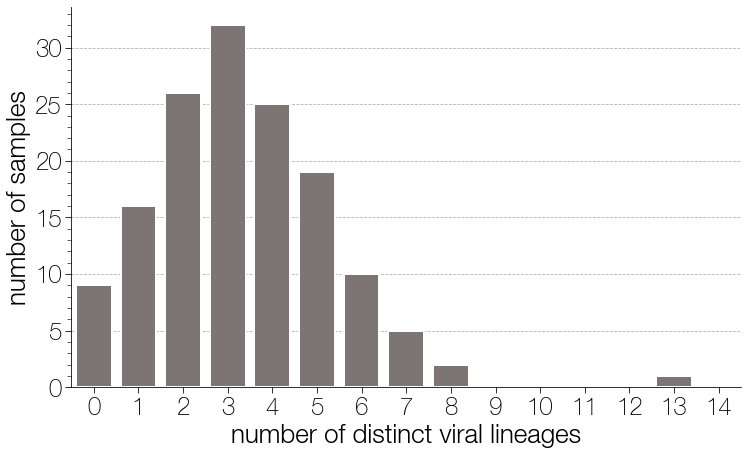

In [3]:
fig,ax = plt.subplots(figsize=(12,7),facecolor='w')

freqs=sample_coinfections.values()
bins=range(0,max(freqs)+3)
ax.hist(freqs,bins=bins,align='left',facecolor='#7C7574',edgecolor='w',rwidth=0.8,lw=2,zorder=10)

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.set_xticks(bins)
ax.set_xlim(-0.5,max(bins)-0.5)

ax.grid(axis='y',ls='--')
ax.tick_params(which='major',size=6,labelsize=24)
ax.tick_params(which='minor',size=4,labelsize=0)

ax.set_ylabel('number of samples',size=26)
ax.set_xlabel('number of distinct viral lineages',size=26)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['left','bottom']]

plt.savefig('/Users/evogytis/Downloads/figS2_coinfection.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Downloads/figS2_coinfection.png',dpi=300,bbox_inches='tight')
plt.show()